In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2


from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten,
                          MaxPool2D)
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2

data_dir = Path('./chest_xray')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

train_normal_cases_dir = train_dir / 'NORMAL'
test_normal_cases_dir = test_dir / 'NORMAL'
train_pneumonia_cases_dir = train_dir / 'PNEUMONIA'
test_pneumonia_cases_dir = test_dir / 'PNEUMONIA'

train_normal_cases = train_normal_cases_dir.glob('*.jpeg')
test_normal_cases = test_normal_cases_dir.glob('*.jpeg')
train_pneumonia_cases = train_pneumonia_cases_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_cases_dir.glob('*.jpeg')

train_data = []
test_data = []
# Load the data into an array, the format of a data entry in the array will be
# (image_location, isPneumonia), where image_location is the location where the image is stored
# and isPneumonia is a boolean which indicates whether the subject of the chest x-ray has pneumonia (1) or not (0)
for img_path in train_normal_cases:
    train_data.append((img_path, 0))
for img_path in train_pneumonia_cases:
    train_data.append((img_path, 1))
for img_path in test_normal_cases:
    test_data.append((img_path, 0))
for img_path in test_pneumonia_cases:
    test_data.append((img_path, 1))
len(train_data), len(test_data)

random.seed(42)
random.shuffle(train_data)
random.shuffle(test_data)

2023-12-11 18:51:50.548469: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 18:51:50.620738: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 18:51:50.621937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 18:51:51.783190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_data = pd.DataFrame(train_data, columns=['image', 'label'], index=None)
test_data = pd.DataFrame(test_data, columns=['image', 'label'], index=None)
# train_data = train_data.sample(frac=1)
# train_data.head()

# Count the number of normal and pneumonia cases in the dataframe
train_data['label'].value_counts(),test_data['label'].value_counts()
train_data

,image,label
0,chest_xray/train/PNEUMONIA/person719_bacteria_...,1
1,chest_xray/train/PNEUMONIA/person940_virus_160...,1
2,chest_xray/train/PNEUMONIA/person1884_bacteria...,1
3,chest_xray/train/PNEUMONIA/person515_bacteria_...,1
4,chest_xray/train/PNEUMONIA/person347_bacteria_...,1
...,...,...
5211,chest_xray/train/PNEUMONIA/person850_bacteria_...,1
5212,chest_xray/train/PNEUMONIA/person1439_bacteria...,1
5213,chest_xray/train/PNEUMONIA/person1087_bacteria...,1
5214,chest_xray/train/NORMAL/NORMAL2-IM-0499-0001.jpeg,0


In [3]:
train_samples = train_data['image'].tolist()
train_labels = train_data['label'].tolist()
test_samples = test_data['image'].tolist()
test_labels = test_data['label'].tolist()
n_train = len(train_samples)
n_test = len(test_samples)

In [4]:
import random
import os


# TODO: dependence of pixel size
parsed_train_samples = np.zeros([1000, 224, 224])
parsed_test_samples =  np.zeros([400, 224, 224])
for i in range(1000):
    img = cv2.imread(str(train_samples[i]), cv2.IMREAD_GRAYSCALE)
    scaled_img = cv2.resize(img, dsize=(224, 224))
    parsed_train_samples[i]=scaled_img
    cv2.imwrite(f"{os.getcwd()}/train_processed/{i}_train.jpeg", scaled_img)
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [5]:
for i in range(400):
    img = cv2.imread(str(test_samples[i]), cv2.IMREAD_GRAYSCALE)
    scaled_img = cv2.resize(img, dsize=(224, 224))
    parsed_test_samples[i]=scaled_img
    cv2.imwrite(f"{os.getcwd()}/test_processed/{i}_train.jpeg", scaled_img)
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

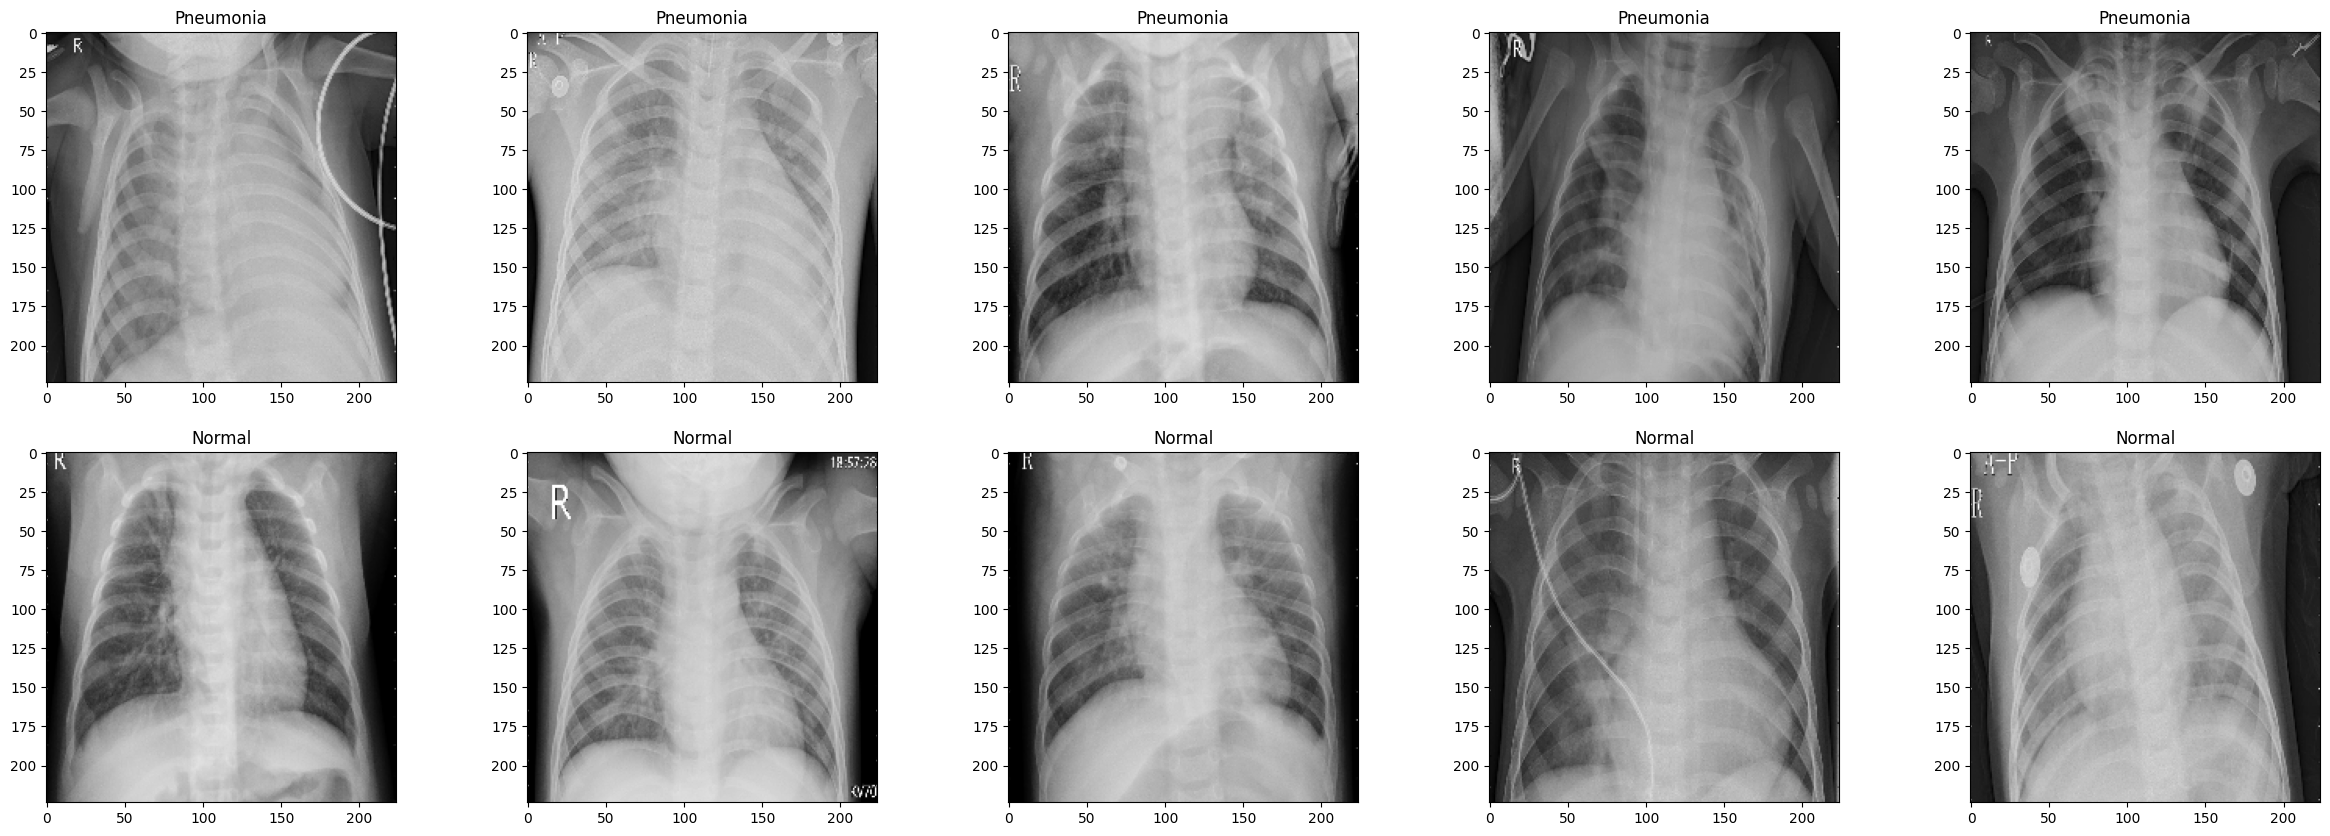

In [6]:
_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    ax[i//5, i%5].imshow(parsed_train_samples[i], cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
plt.show()

In [7]:
# Model
def model_gen():
    model = Sequential()

    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224,224,1), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224,224,1), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units = 256 , activation = 'relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(units = 128 , activation = 'relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1 , activation = 'sigmoid'))

    model.summary()
    return model

In [8]:
model=model_gen()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      128       
 chNormalization)                                                
                                                        

In [9]:
model.fit(np.array(parsed_train_samples), np.array(train_labels[0:1000]), epochs=5, batch_size=32)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Epoch 1/5
32/32 [==============================] - 50s 2s/step - loss: 13.7123 - accuracy: 0.8090
Epoch 2/5
32/32 [==============================] - 46s 1s/step - loss: 11.0775 - accuracy: 0.8630
Epoch 3/5
32/32 [==============================] - 46s 1s/step - loss: 8.0929 - accuracy: 0.8960
Epoch 4/5
32/32 [==============================] - 46s 1s/step - loss: 6.3121 - accuracy: 0.9130
Epoch 5/5
32/32 [==============================] - 44s 1s/step - loss: 5.1464 - accuracy: 0.9260
Saved model to disk


In [10]:
model.evaluate(np.array(parsed_test_samples), np.array(test_labels[0:400]))

13/13 [==============================] - 4s 271ms/step - loss: 5.6168 - accuracy: 0.8725


[5.616753101348877, 0.8725000023841858]

In [12]:
# import numpy as np
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [62]:
loaded_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
test_pred = loaded_model.predict(np.array(parsed_test_samples))



13/13 [==============================] - 3s 206ms/step


In [65]:
from sklearn.metrics import classification_report
import copy

# print(test_pred[0:5])
f_scores=[]
for threshold in np.arange(0, 1, 0.1):
    # print(test_pred[0:5])
    test_pred2=copy.deepcopy(test_pred)
    test_pred2=(test_pred2>threshold)*1
    # print(threshold)
    f_scores.append(classification_report(test_labels[0:400],test_pred2, output_dict=True)['weighted avg']['f1-score'])
(np.array(f_scores))

/home/omkar/Documents/Github/PneumCNN/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omkar/Documents/Github/PneumCNN/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omkar/Documents/Github/PneumCNN/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

array([0.46531008, 0.87839271, 0.87839271, 0.87352299, 0.87108826,
       0.87360995, 0.87620353, 0.87620353, 0.8688822 , 0.86399898])

In [ ]:
print(classification_report(test_pred))